# Image analysis with Gammapy

## Introduction

This tutorial shows how to make a significance image of the Crab nebula with Gammapy.

The `SkyImage.plot` method uses [wcsaxes](http://wcsaxes.readthedocs.io/en/latest/), so you should install that.

* Use the [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)
  to load [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html) data.
* Fill the events in a [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)


* We'll use the [astropy.convolution.Tophat2DKernel](http://docs.astropy.org/en/latest/api/astropy.convolution.Tophat2DKernel.html) and 
 [astropy.convolution.Ring2DKernel](http://docs.astropy.org/en/latest/api/astropy.convolution.Ring2DKernel.html) kernels and the [gammapy.detect.KernelBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.KernelBackgroundEstimator.html) to estimate the background.
* Run [gammapy.scripts.StackedObsImageMaker](http://docs.gammapy.org/en/latest/api/gammapy.scripts.StackedObsImageMaker.html) to get images and PSF.


TODO: Refactor [gammapy.scripts.image_fit](http://docs.gammapy.org/en/latest/api/gammapy.scripts.image_fit.html) into a class (simiar to `gammapy.spectrum.SpectrumFit`) and run it here to fit a Gauss and get the position / extension.

## Setup

As usual, IPython notebooks start with some setup and Python imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import wcsaxes # not used directly, just to make sure it's installed

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Ring2DKernel, Tophat2DKernel

from gammapy.data import DataStore
from gammapy.image import SkyImage, SkyImageList
from gammapy.detect import KernelBackgroundEstimator as KBE

## Dataset

We will use the `gammapy.data.DataStore` to access some example data.

These are observations of the Crab nebula with H.E.S.S. (preliminary, events are simulated for now).

In [3]:
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')

## Counts image

Let's make a counts image using the `SkyMap` class.

In [4]:
source_pos = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# source_pos = SkyCoord.from_name('crab')
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>


In [5]:
ref_image = SkyImage.empty(
    nxpix=400, nypix=400, binsz=0.02,
    xref=source_pos.ra.deg, yref=source_pos.dec.deg,
    coordsys='CEL', proj='TAN',
)

In [6]:
# Make a counts image for a single observation
events = data_store.obs(obs_id=23523).events
counts_image = SkyImage.empty_like(ref_image)
counts_image.fill_events(events)

(<matplotlib.figure.Figure at 0x7fe1197b0160>,
 <matplotlib.colorbar.Colorbar at 0x7fe1133a7358>)

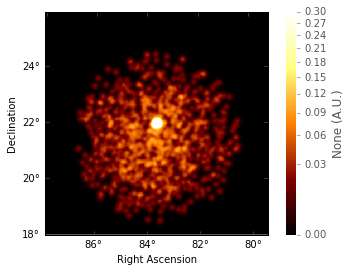

In [7]:
norm = counts_image.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.3)
counts_image.smooth(width=3).plot(norm=norm, add_cbar=True)

In [8]:
# Making a counts image for multiple observations is a bit inconvenient at the moment
# we'll make that better soon.
# For now, you can do it like this:
obs_ids = [23523, 23526]
counts_image2 = SkyImage.empty_like(ref_image)
for obs_id in obs_ids:
    events = data_store.obs(obs_id=obs_id).events
    counts_image2.fill_events(events)

(<matplotlib.figure.Figure at 0x7fe11312dcf8>,
 <matplotlib.colorbar.Colorbar at 0x7fe1131135c0>)

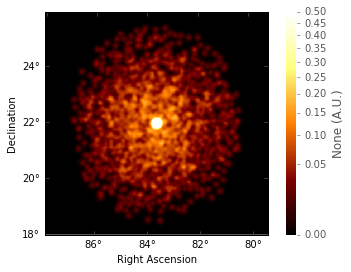

In [9]:
norm = counts_image2.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.5)
counts_image2.smooth(width=3).plot(norm=norm, add_cbar=True)

# Background modeling

In Gammapy a few different methods to estimate the background are available.

Here we'll use the [gammapy.detect.KernelBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.KernelBackgroundEstimator.html) to make a background image
and the make a significance image.

In [10]:
source_kernel = Tophat2DKernel(radius=5)
source_kernel.normalize(mode='peak')
source_kernel = source_kernel.array

background_kernel = Ring2DKernel(radius_in=20, width=10)
background_kernel.normalize(mode='peak')
background_kernel = background_kernel.array

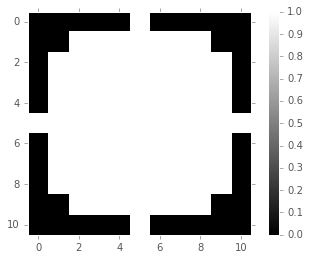

In [11]:
plt.imshow(source_kernel, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.grid('off')

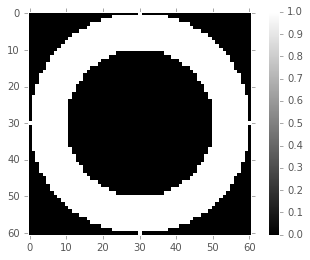

In [12]:
plt.imshow(background_kernel, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.grid('off')

In [13]:
# To use the `KernelBackgroundEstimator` you first have to set
# up a source and background kernel and put the counts image input
# into a container `SkyImageList` class.
images = SkyImageList()
images['counts'] = counts_image2

kbe = KBE(
    kernel_src=source_kernel,
    kernel_bkg=background_kernel,
    significance_threshold=5,
    mask_dilation_radius=0.06 * u.deg,
)
# This takes about 10 seconds on my machine
result = kbe.run(images)

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:237: RuntimeWarning: invalid value encountered in greater_equal
  mask = (n_on >= n_on_min)
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: invalid value encountered in sqrt
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)
/home/hfm/adonath/Software/Repositories/gammapy/gammapy/detect/kernel.py:185: RuntimeWarning: invalid value encountered in less
  mask = (significance.data < p['significance_threshold']) | np.isnan(significance)


In [14]:
# Let's have a look at the background image and the exclusion mask

# This doesn't work yet ... need to do SkyImage.plot fixes:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
# background_image.plot(ax=axes[0])
# exclusion_image.plot(ax=axes[1])
# significance_image.plot(ax=axes[2])

(<matplotlib.figure.Figure at 0x7fe113345e48>,
 <matplotlib.colorbar.Colorbar at 0x7fe112e22320>)

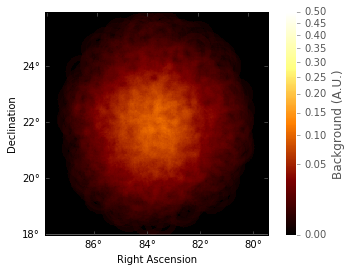

In [15]:
background_image = result['background']
norm = background_image.plot_norm(stretch='sqrt', min_cut=0, max_cut=0.5)
background_image.plot(norm=norm, add_cbar=True)

(<matplotlib.figure.Figure at 0x7fe119738ba8>,
 None)

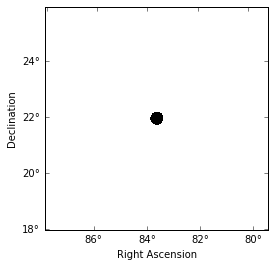

In [16]:
result['exclusion'].plot()

(<matplotlib.figure.Figure at 0x7fe112dd80f0>,
 <matplotlib.colorbar.Colorbar at 0x7fe112d2bcc0>)

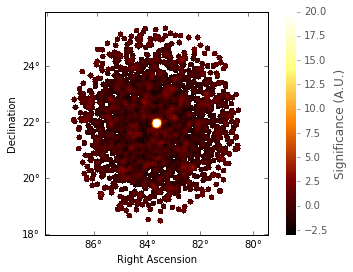

In [17]:
significance_image = result['significance']
norm = significance_image.plot_norm(stretch='linear', min_cut=-3, max_cut=20)
significance_image.plot(norm=norm, add_cbar=True)

## Morphology fit

TODO

In [18]:
# from gammapy.scripts import image_fit

## Exercises

- Compute the counts, excess, background and significance at the Crab nebula position.
- Make an energy distribution of the events at the Crab nebula position.

## What next?

TODO: summarise

TODO: give links what to do next.